In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as st
from toolz import partition

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### 9.2 Fixed-effects ANOVA

#### 9.2.1 Data generation

In [2]:
np.random.seed(67)
ngroups = 5                       
nsample = 10                     
pop_means = np.array([50, 40, 45, 55, 60])
sigma = 3                        

n = ngroups * nsample                     
eps = st.norm.rvs(0, sigma, size = n)                       
x = np.repeat(np.arange(1,6), nsample)
means = np.repeat(pop_means, nsample)
X = pd.get_dummies(x).to_numpy()
y = X @ pop_means + eps

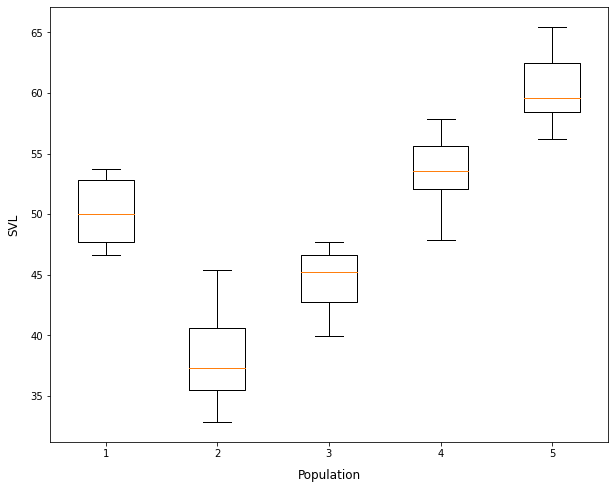

In [3]:
plt.figure(figsize = (10, 8))
plt.boxplot([y[:10], y[10:20], y[20:30], y[30:40], y[40:50]])
plt.xlabel('Population', fontsize = 12, labelpad = 10)
plt.ylabel('SVL', fontsize = 12, labelpad = 10);

In [4]:
idx = pd.factorize(x)[0]
groups = len(np.unique(idx))

In [5]:
with pm.Model() as model_9_2_3:
    alpha = pm.Normal('alpha', mu = 0, tau = 0.001, shape = groups)
    sigma = pm.Uniform('sigma', 0, 100)
    
    y_pred = pm.Normal('Y', mu = alpha[idx], sigma = sigma, observed = y)
    
    effect2 = pm.Deterministic('effect2', alpha[1] - alpha[0])
    effect3 = pm.Deterministic('effect3', alpha[2] - alpha[0])
    effect4 = pm.Deterministic('effect4', alpha[3] - alpha[0])
    effect5 = pm.Deterministic('effect5', alpha[4] - alpha[0])
    
    test1 = pm.Deterministic('test1', (effect2 + effect3) - (effect4 + effect5))    # Equals zero when 2+3 = 4+5
    test2 = pm.Deterministic('test2', effect5 - 2 * effect4)                        # Equals zero when effe5 = 2*effe4
    
    trace_9_2_3 = pm.sample(5000, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 28 seconds.


In [6]:
az.summary(trace_9_2_3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],50.022,0.993,48.144,51.864,0.008,0.006,14952.0,8140.0,1.0
alpha[1],38.092,1.010,36.193,39.991,0.008,0.006,14401.0,7152.0,1.0
alpha[2],44.503,0.979,42.628,46.271,0.009,0.006,11950.0,8171.0,1.0
alpha[3],53.590,0.996,51.722,55.456,0.008,0.006,13835.0,8258.0,1.0
alpha[4],60.369,1.000,58.496,62.210,0.009,0.006,13449.0,8038.0,1.0
sigma,3.130,0.335,2.525,3.768,0.004,0.003,9240.0,7164.0,1.0
effect2,-11.930,1.430,-14.647,-9.225,0.011,0.008,15923.0,8190.0,1.0
effect3,-5.518,1.386,-8.069,-2.842,0.012,0.009,12832.0,7733.0,1.0
effect4,3.568,1.411,0.847,6.160,0.012,0.009,14362.0,7771.0,1.0
effect5,10.347,1.405,7.592,12.870,0.012,0.009,13855.0,8205.0,1.0


### 9.3 Random-effects ANOVA

#### 9.3.1 Data generation

In [7]:
np.random.seed(67)
npop = 10
nsample = 12
n = npop * nsample
pop_grand_mean = 50
pop_sd = 5
pop_means = st.norm.rvs(pop_grand_mean, pop_sd, size = npop)
sigma = 3
eps = st.norm.rvs(0, sigma, size = n)
x = np.repeat(np.arange(npop), nsample)
X = pd.get_dummies(x).to_numpy()
y = X @ pop_means + eps

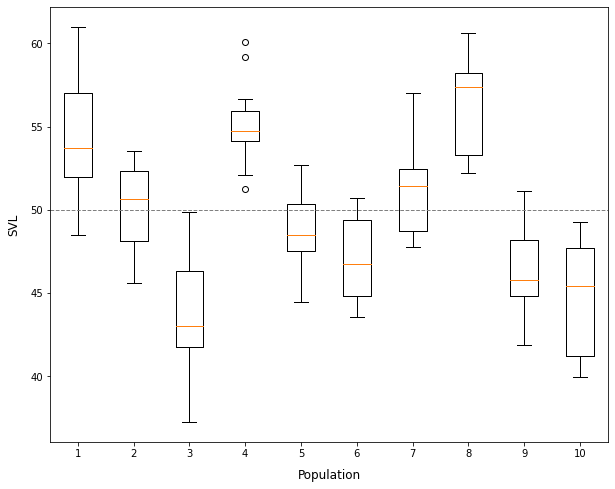

In [8]:
y_boxplot = list(partition(12, y))
plt.figure(figsize = (10, 8))
plt.boxplot(y_boxplot)
plt.xlabel('Population', fontsize = 12, labelpad = 10)
plt.ylabel('SVL', fontsize = 12, labelpad = 10)
plt.axhline(50, 0, 10, lw = 1, ls = '--', color = 'gray');

#### 9.3.2 REML using *statsmodels*

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [10]:
data = pd.DataFrame({'y': y, 'x': x})

In [11]:
lme = smf.mixedlm("y ~ 1", data, groups = x)

In [12]:
lme_fit = lme.fit()
print(lme_fit.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: y        
No. Observations: 120     Method:             REML     
No. Groups:       10      Scale:              8.5800   
Min. group size:  12      Log-Likelihood:     -314.0864
Max. group size:  12      Converged:          Yes      
Mean group size:  12.0                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    49.751    1.407 35.348 0.000 46.992 52.509
Group Var    19.095    3.316                           



In [13]:
# Print random effects
print('Group         intercept')
for group, re in enumerate(lme_fit.random_effects.values()):
    print(f'  {group}       {(round(re[0], 7))}')

Group         intercept
  0       4.3376031
  1       0.4474786
  2       -5.9427963
  3       5.2746897
  4       -1.0318564
  5       -2.6225714
  6       1.3566531
  7       6.2810389
  8       -3.1973248
  9       -4.9029146


#### 9.3.3 Bayesian analysis

In [14]:
idx = pd.factorize(x)[0]
groups = len(np.unique(idx))

In [15]:
with pm.Model() as model_9_3_3:
    
    μ = pm.Normal('μ', mu = 0, tau = 0.001)
    σ_group = pm.Uniform('σ_group', 0, 10)
    pop_mean = pm.Normal('pop_mean', mu = μ, sigma = σ_group, shape = groups)
    σ_res = pm.Uniform('σ_res', 0, 10)
    effe = pm.Deterministic('effe', pop_mean - μ)
    
    y_new = pm.Normal('Y', mu = pop_mean[idx], sigma = σ_res, observed = y)
    
    trace_9_3_3 = pm.sample(5000, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ_res, pop_mean, σ_group, μ]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 32 seconds.


In [16]:
az.summary(trace_9_3_3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,49.599,1.641,46.415,52.602,0.016,0.012,10262.0,6702.0,1.0
pop_mean[0],54.095,0.836,52.528,55.662,0.007,0.005,15738.0,7285.0,1.0
pop_mean[1],50.195,0.839,48.623,51.749,0.007,0.005,16205.0,7082.0,1.0
pop_mean[2],43.789,0.849,42.212,45.370,0.007,0.005,14424.0,7519.0,1.0
pop_mean[3],55.026,0.843,53.439,56.610,0.007,0.005,15643.0,7860.0,1.0
pop_mean[4],48.710,0.853,47.115,50.299,0.007,0.005,14952.0,7662.0,1.0
pop_mean[5],47.124,0.838,45.605,48.742,0.006,0.005,17030.0,7759.0,1.0
pop_mean[6],51.115,0.842,49.572,52.742,0.007,0.005,15070.0,6867.0,1.0
pop_mean[7],56.056,0.852,54.485,57.710,0.007,0.005,15330.0,7773.0,1.0
pop_mean[8],46.567,0.844,45.054,48.194,0.007,0.005,14313.0,6258.0,1.0
